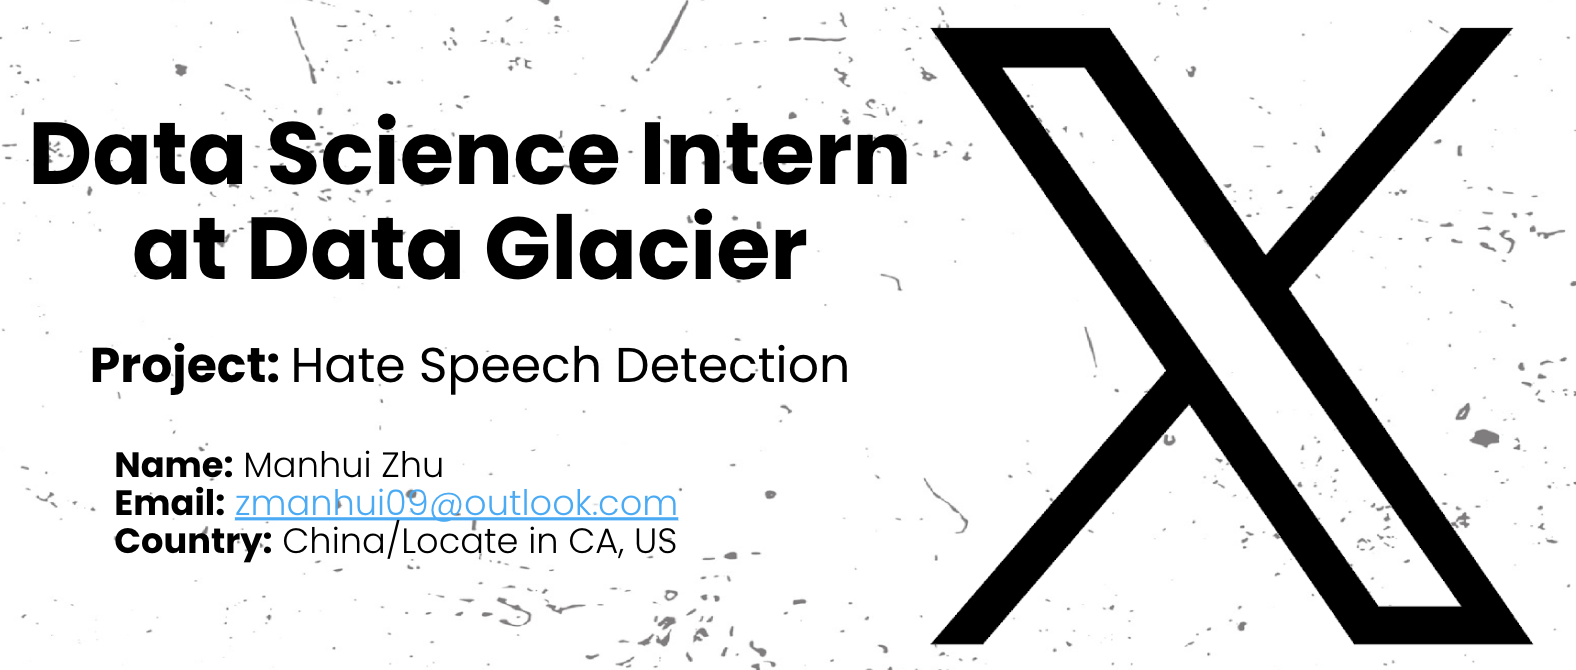

# Problem Statement

The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. In this problem, I will take you through a hate speech detection model with Machine Learning and Python.

Hate Speech Detection is generally a task of sentiment classification. A model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, I will use the Twitter tweets to identify tweets containing  Hate speech.



$\rule{800pt}{20pt}$

# 1. Import libraries and datadet

## 1.1 Import libraries and packages

In [ ]:
!pip install transformers==4.30.0
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# Load All Packages

# Basic
import os
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
import re
import string
import nltk

# EDA
from itertools import chain
from collections import Counter
from wordcloud import WordCloud
from sklearn.utils import resample

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from transformers import BertTokenizer, BertModel
import torch

# Model building and training
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import TFBertForSequenceClassification, BertTokenizer

# Model Performance Evaluation
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import precision_recall_curve


## 1.2 Import Dataset

In [ ]:
# Navigate to Directory
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Data Glacier")

Mounted at /content/drive


## 1.3 Read the data

In [ ]:
filepath = './Week 7-13: Hate Speech Detection Project (NLP)/'

speech = pd.read_csv(filepath + 'hate_speech.csv')

In [ ]:
speech.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
speech.tail()

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


## 1.3 Data information: number of columns and observatons, data type

In [ ]:
speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
speech.shape

(31962, 3)

There are 31962 tweets and 3 variables in the dataset.

## 1.4 Check the missing values and duplicated values

In [ ]:
speech.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
speech.duplicated().sum()

0

There is no missing values in our dataset, and each row has unique value.

$\rule{800pt}{20pt}$

# 2. Data Preprocessing

## 2.1 Text Cleaning

We can use the Regular Expression (`re`) package to help remove URLs and user mention and other special characters.

*   **Lowercasing**: Convert text to lowercase to ensure uniformity
*   **Remove User Mentions**: Strip out Twitter handles (eg. `@user`)
*   **Remove URLs**: Strip out URLs from the tweets
*   **Remove Special Characters**: Remove punctuation, special characters
*   **Remove leading and trailing whitespace**




In [ ]:
def clean_tweet(tweet):
  '''Text Cleaning'''
  tweet = tweet.lower()      # lowercase
  tweet = re.sub(r'@[\w]*', '', tweet)     # remove @user
  # [\w]: a character class that matches any alphanumeric character
  # or underscore (equivalent to [A-Za-z0-9_])
  # *: a quantifier that matches zero or more occurrences of the preceding character class.

  tweet = re.sub(r'http\S+', '', tweet)    # remove URLs
  # http: Matches the literal string "http".
  # \S: Matches any non-whitespace character.
  # +: Quantifier that matches one or more of the preceding token (non-whitespace characters)

  special_chars = r'[^a-zA-Z\s]'  # Keep only letters, and whitespace
  tweet = re.sub(special_chars, '', tweet)     # remove digits and special characters

  tweet = tweet.strip()     # Remove leadind and trailing whitespace

  return tweet


In [ ]:
speech['tweet'] = speech['tweet'].apply(clean_tweet)

## 2.2 Remove stop words

Remove words that appeared frequently like 'and', 'is', 'the' but may not contribute to the meaning of the sentence. We use the `nltk` library and download thr stop words list to remove stop words.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# get the list of enligh stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

In [ ]:
speech['nostop_tweet'] = speech['tweet'].apply(lambda x: ' '.join(remove_stop_words(x.split())))

In [ ]:
speech.head()

,id,label,tweet,nostop_tweet
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks for lyft credit i cant use cause they d...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,model i love u take with u all the time in ur,model love u take u time ur
4,5,0,factsguide society now motivation,factsguide society motivation


## 2.3 Tokenization

Split tweets into individual words (tokens)

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

speech['tokenized_tweet'] = speech['nostop_tweet'].apply(word_tokenize)
speech.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,id,label,tweet,nostop_tweet,tokenized_tweet
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunctional selfish drags kids dysfun...,"[father, dysfunctional, selfish, drags, kids, ..."
1,2,0,thanks for lyft credit i cant use cause they d...,thanks lyft credit cant use cause dont offer w...,"[thanks, lyft, credit, cant, use, cause, dont,..."
2,3,0,bihday your majesty,bihday majesty,"[bihday, majesty]"
3,4,0,model i love u take with u all the time in ur,model love u take u time ur,"[model, love, u, take, u, time, ur]"
4,5,0,factsguide society now motivation,factsguide society motivation,"[factsguide, society, motivation]"


## 2.4 Lemmatization

Reduce words to their base or root form by considering the context meaning of the word. It uses a dictionary-based approach to return the lemma, which is the base form of a word.

In [ ]:
from textblob import Word
nltk.download('wordnet')

speech['clean_tweet'] = speech['nostop_tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
speech.head()

,id,label,tweet,nostop_tweet,tokenized_tweet,clean_tweet
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunctional selfish drags kids dysfun...,"[father, dysfunctional, selfish, drags, kids, ...",father dysfunctional selfish drag kid dysfunct...
1,2,0,thanks for lyft credit i cant use cause they d...,thanks lyft credit cant use cause dont offer w...,"[thanks, lyft, credit, cant, use, cause, dont,...",thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty,"[bihday, majesty]",bihday majesty
3,4,0,model i love u take with u all the time in ur,model love u take u time ur,"[model, love, u, take, u, time, ur]",model love u take u time ur
4,5,0,factsguide society now motivation,factsguide society motivation,"[factsguide, society, motivation]",factsguide society motivation


$\rule{800pt}{20pt}$

# 3. EDA (Exploratory Data Analysis)

## 3.1 Number of words in each tweet (before and after removing stop words) & number of stop words in tweet

In [ ]:
# Number of words in tweet

df = pd.DataFrame()

df['tweet'] = speech['tweet']
df['word_count'] = speech['tweet'].apply(lambda x: len(x.split()))

In [ ]:
# Number of stop words in tweet

df['stopwords_count'] = df['tweet'].apply(lambda x:
                                          len([x for x in x.split() if x in stop_words]))

df['nostop_word_count'] = df['word_count'] - df['stopwords_count']
df.head()

,tweet,word_count,stopwords_count,nostop_word_count
0,when a father is dysfunctional and is so selfi...,17,10,7
1,thanks for lyft credit i cant use cause they d...,17,4,13
2,bihday your majesty,3,1,2
3,model i love u take with u all the time in ur,12,5,7
4,factsguide society now motivation,4,1,3


In [ ]:
# maximum number of words in tweets before removing stop words
df['word_count'].max()

33

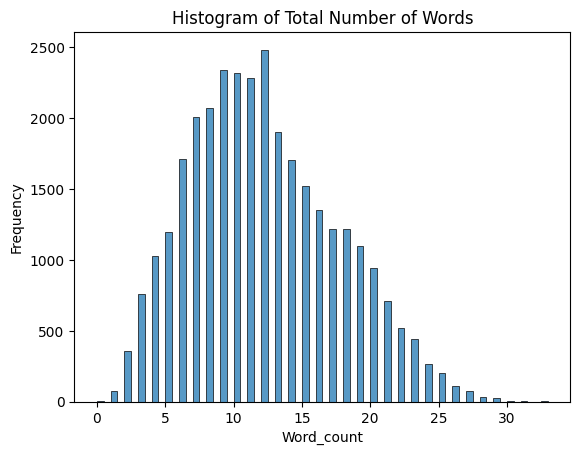

In [ ]:
# Histogram of total number of words

sns.histplot(df['word_count'])
plt.title('Histogram of Total Number of Words')
plt.xlabel('Word_count')
plt.ylabel('Frequency')
plt.show()

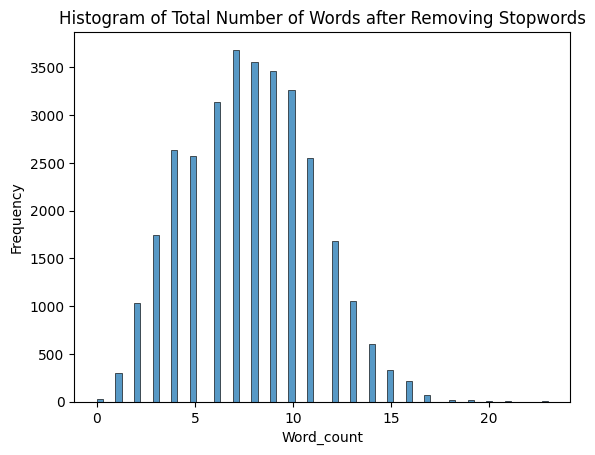

In [ ]:
# Histogram of total number of words after removing stop words

sns.histplot(df['nostop_word_count'])
plt.title('Histogram of Total Number of Words after Removing Stopwords')
plt.xlabel('Word_count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# maximum number of words in tweets before removing stop words
df['nostop_word_count'].max()

23

## 3.2 The most frequent words in the whole dataset

In [ ]:
# Flatten the list of tokenized tweets
all_tokens = list(chain.from_iterable(speech['tokenized_tweet']))

# Count word frequencies
word_counts = Counter(all_tokens)

# Top 10 most frequent words
word_counts.most_common(10)

[('love', 2726),
 ('day', 2290),
 ('happy', 1691),
 ('amp', 1608),
 ('im', 1157),
 ('u', 1148),
 ('life', 1127),
 ('time', 1126),
 ('like', 1053),
 ('today', 1008)]

In [ ]:
# total number of unique words
len(word_counts)

39591

<ipython-input-169-960f32ac4441>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'frequency', y = 'word',


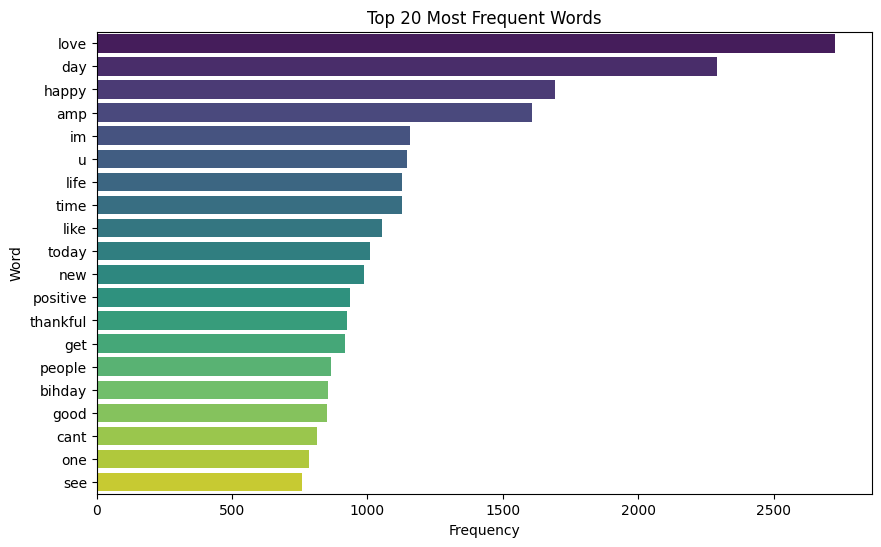

In [ ]:
word_freq = pd.DataFrame(word_counts.most_common(20),
                         columns = ['word', 'frequency'])

plt.figure(figsize = (10, 6))
sns.barplot(x = 'frequency', y = 'word',
            data = word_freq,
            palette = 'viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## 3.3 The most frequent words in hate tweets and non-hate tweets

In [ ]:
df = speech[['id', 'label', 'tokenized_tweet']]

group_df = df.groupby('label')['tokenized_tweet']

In [ ]:
# Create a dictionary to store word counts for each label
word_counts_by_label = {}

for label, tweets in group_df:
    all_tokens = list(chain.from_iterable(tweets))
    word_counts = Counter(all_tokens)
    word_counts_by_label[label] = word_counts

<ipython-input-172-e427d2d64f93>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data = nonhate_df,
<ipython-input-172-e427d2d64f93>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data = hate_df,


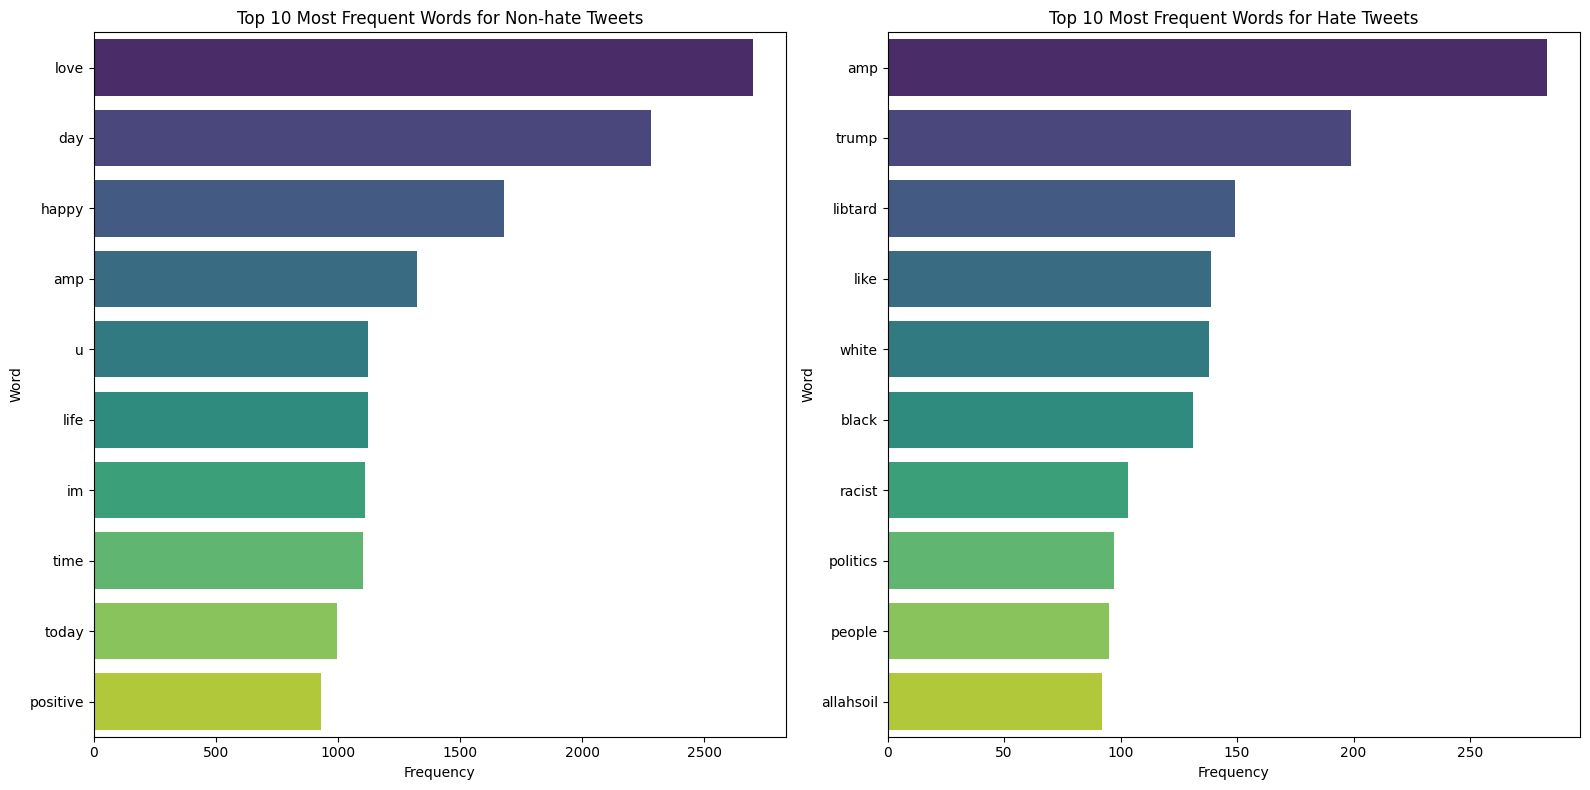

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# top 10 frequent words in non-hate tweets
nonhate_top_words = word_counts_by_label[0].most_common(10)
nonhate_df = pd.DataFrame(nonhate_top_words, columns=['word', 'frequency'])
sns.barplot(x='frequency', y='word', data = nonhate_df,
            palette='viridis', ax=axes[0])
axes[0].set_title(f'Top 10 Most Frequent Words for Non-hate Tweets')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# top 10 frequent words in hate tweets
hate_top_words = word_counts_by_label[1].most_common(10)
hate_df = pd.DataFrame(hate_top_words, columns=['word', 'frequency'])
sns.barplot(x='frequency', y='word', data = hate_df,
            palette='viridis', ax=axes[1])
axes[1].set_title(f'Top 10 Most Frequent Words for Hate Tweets')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 3.4 Word Cloud for each label

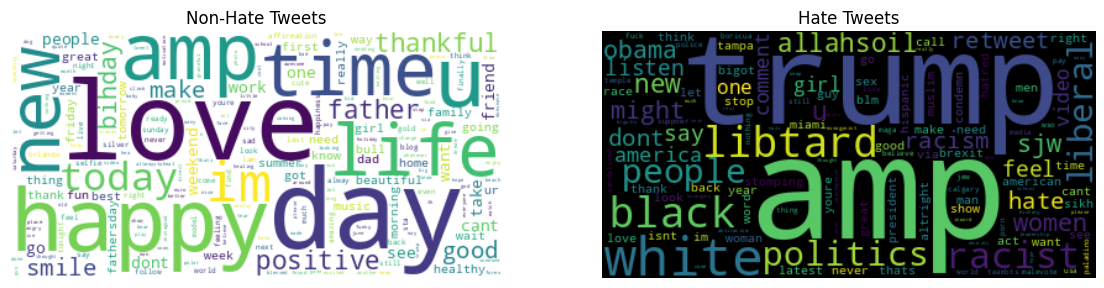

In [ ]:
fig, axs = plt.subplots(1,2 , figsize=(14,8))

# prepare the text data
non_hate = " ".join(speech['nostop_tweet'][speech['label'] == 0])
hate = " ".join(speech['nostop_tweet'][speech['label'] == 1])

# Word cloud for non-hate tweets
nonhate_cloud = WordCloud(collocations = False, background_color = 'white').generate(non_hate)
axs[0].imshow(nonhate_cloud, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Tweets')

# Word cloud for hate tweets
hate_cloud = WordCloud(collocations = False, background_color = 'black').generate(hate)
axs[1].imshow(hate_cloud, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Tweets')

plt.show()

## 3.5 Check total number of hate speech and non-hate speech

In [ ]:
speech['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

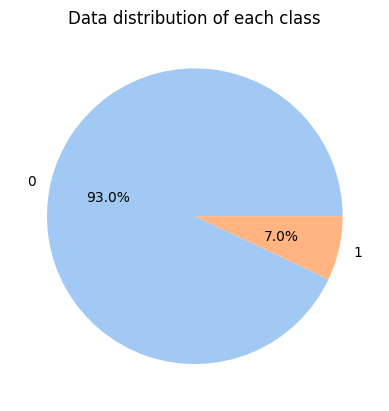

In [ ]:
data = speech['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(data, labels=data.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))

# Set title and display
ax.set_title('Data distribution of each class')
plt.show()

It is obvious that the dataset is imbalanced, there are far more non-hate tweets than hate tweets. To solve this problem, we can resample hate speech samples with replacements (duplicate minority samples) to increasing the number of samples of hate tweets (label = 1).

## 3.6 Solve the imbalance issue

In [ ]:
df_nohate = speech[speech.label == 0]
df_hate = speech[speech.label == 1]

# Upsample minority class
df_hate_upsampled = resample(df_hate,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_nohate),    # match number in majority class
                                 random_state=123)

# Combine non-hate tweet with upsampled hate tweet
speech_new = pd.concat([df_nohate, df_hate_upsampled])

# Display new class counts
print(speech_new['label'].value_counts())

label
0    29720
1    29720
Name: count, dtype: int64


In [ ]:
speech_new.reset_index(drop = True, inplace = True)
speech_new.drop(columns = ['id'], inplace = True)

In [ ]:
speech_new.isnull().sum()

label              0
tweet              0
nostop_tweet       0
tokenized_tweet    0
clean_tweet        0
dtype: int64

In [ ]:
speech_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59440 entries, 0 to 59439
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            59440 non-null  int64 
 1   tweet            59440 non-null  object
 2   nostop_tweet     59440 non-null  object
 3   tokenized_tweet  59440 non-null  object
 4   clean_tweet      59440 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


Now we have the same number of samples in each label, and there is no missing value in the dataset.

In [ ]:
speech_new.tail()

,label,tweet,nostop_tweet,tokenized_tweet,clean_tweet
59435,1,homicides rose in most big cities this year t...,homicides rose big cities year wall street jou...,"[homicides, rose, big, cities, year, wall, str...",homicide rose big city year wall street journa...
59436,1,the major kind of that people arent talking e...,major kind people arent talking enough via env...,"[major, kind, people, arent, talking, enough, ...",major kind people arent talking enough via env...
59437,1,he may be correct i just cant pay attention to...,may correct cant pay attention communist,"[may, correct, cant, pay, attention, communist]",may correct cant pay attention communist
59438,1,a look at the repug gop pay bigots at,look repug gop pay bigots,"[look, repug, gop, pay, bigots]",look repug gop pay bigot
59439,1,it is truly sad a who lot of working class men...,truly sad lot working class men resent offered...,"[truly, sad, lot, working, class, men, resent,...",truly sad lot working class men resent offered...


In [ ]:
# save this new dataset as a csv file

file_path = '/content/drive/MyDrive/Data Glacier/Week 7-13: Hate Speech Detection Project (NLP)/speech_new.csv'

speech_new.to_csv(file_path, index = False)

$\rule{800pt}{20pt}$

# 4. Feature Extraction

## 4.1 Bag of Words (BoW)

This method converts text into a matrix of token counts (numerical representations), ignoring grammar and word order but keeping multiplicity. The intuition behind this method is that similar text fields will contain similar kind of words, therefore having similar bag of words.

It has three steps: the first step is **tokenization**, splitting the text into individual words and tokens; the second step is **vocabulary**, it creates a set of unique words (tokens) from the entire text corpus; the last step is **vectorization**, converting each document into a vector where each dimension corresponds to a word from the vocabulary and the value represents the word's frequency in the document.

**Dimension Reduction**: Natural language data can have a very high dimensionality because each unique word in the corpus can be a feature. By setting `max_features = 4000`, we limit the feature space to the most important 4000 terms based on their frequencies (in BoW techinque) or TF-IDF scores (in TD-IDF technique). It reduces the computational complexity and memory usage of my model.

In [ ]:
# select the top 5000 terms with the highest frequency
vectorizer = CountVectorizer(max_features = 4000)

# Fit and transform the text data
# learn the vocabulary and computes the term-document matrix

bow_X = vectorizer.fit_transform(speech_new['clean_tweet'])

# Convert to array
bow_X_array = bow_X.toarray()

In [ ]:
# the first 10 vocabularies/features
vectorizer.get_feature_names_out()[:10]

array(['aampe', 'aande', 'aap', 'abe', 'abetting', 'able', 'ableism',
       'aboion', 'absolute', 'absolutely'], dtype=object)

In [ ]:
# BoW representation of the first 10 features
bow_X_array[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# the shape of word vector
bow_X_array[0].shape

(4000,)

## 4.2 TF-IDF (Term Frequency - Inverse Document Frequency)

This method evaluates the importance of a word in a document relative to a collection of documents (corpus), reducing the weight of common words.


*   Term Frequency (TF): Measures how frequently a term occurs in a document. The assumption is that terms that appear more frequently within a document are more important.

$$TF(t, d) = \frac{\text{Number of term t appears in document d}}{\text{Total number of terms in document d}}$$

\\
*   Inverse Document Frequency (IDF): Measures how important a term is within the entire corpus. It helps reduce the weight of terms that occur very frequently in many documents and increase the weight of terms that occur rarely.

$$IDF(t, D) = \log(\frac{\text{Total number of documents}}{\text{Number of documents containing term t}})$$

\\
*    The TF-IDF score is the product of TF and IDF:

$$TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)$$

In [ ]:
vectorizer = TfidfVectorizer(max_features = 4000)
tf_idf_X = vectorizer.fit_transform(speech_new['clean_tweet']).toarray()

tf_idf_X.shape

(59440, 4000)

In [ ]:
# save the vectorizer

vectorizer_file = '../Keras_model/vectorizer.pkl'
with open(vectorizer_file, 'wb') as file:
  pickle.dump(vectorizer, file)

## 4.3 Word Embeddings

This method represents words in a dense vector space, capturing semantic relationships. Words with similar meanings are located close to each other in this vector space.

Word embeddings are typically trained on large text corpora using neural networks. Here, we use the pre-trained `Word2Vec` models developed by Google (`GoogleNews-vectors-negative300.bin`), which contains vectors for a large vocabulary of around 3 million words and phrases. Each word vector is represented in a 300-dimensional space.

Twitter language is full of slang, abbreviations, and emojis. Word2Vec can learn these informal and evolving expressions, leading to accurate detection of hate tweets.

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/DSO 560 Natural Language Processing/Homework/GoogleNews-vectors-negative300.bin'

# load the model
word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
# prepare data
tokenized_data = speech_new['clean_tweet'].apply(word_tokenize)

# Convert Tokens to Vectors
def get_word_vectors(tokens, model):
    ''' Use the pre-trained Word2Vec model to get the vectors for each token.
    Handle words not in the vocabulary by skipping them.'''
    vector_size = model.vector_size
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
        else:
            vectors.append(np.zeros(vector_size))
    return vectors

# Get word vectors for each tokenized sentence
word_vectors_data = [get_word_vectors(tokens, word2vec) for tokens in tokenized_data]

In [ ]:
# check the shape of each word vector
word_vectors_data[0][0].shape

(300,)

In [ ]:
len(word_vectors_data)

59440

In [ ]:
word2vec_vector = word_vectors_data

Since we uses the Google Word2Vec model (GoogleNews-vectors-negative300.bin), each word vector is expected to have 300 dimensions.

In [ ]:
# get the sentence vector (average the word vectors to get a single vector for the sentence)

def average_word_vectors(word_vectors):
    ''' average the word vectors to get a single vector
    representing the entire sentence'''
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec.vector_size)

# Compute the average word vector for each sentence
sentence_vectors = [average_word_vectors(word_vectors) for word_vectors in word_vectors_data]

In [ ]:
# representation of word embedding features for the first tweet
sentence_vectors[0]

array([ 0.08586775,  0.09837995, -0.15330288,  0.13682339, -0.18272182,
        0.03116281,  0.05361938, -0.09708077,  0.15420096,  0.06961495,
        0.12472098, -0.04781669,  0.16214426, -0.0229841 , -0.09504046,
        0.12109375,  0.09514509,  0.15332031, -0.0403377 , -0.04932186,
        0.0773577 ,  0.10138811,  0.13537598,  0.02515847,  0.13225447,
        0.00345285, -0.01906913,  0.10982841,  0.10797991, -0.04180908,
       -0.03771755,  0.00079564,  0.00591169,  0.08084542, -0.03358677,
        0.02613177,  0.17134531, -0.0667899 ,  0.01578195,  0.09384155,
        0.21326555, -0.03771101,  0.07446289, -0.12663923,  0.02121408,
        0.12151228, -0.06895228,  0.08642578, -0.02364676,  0.01131766,
       -0.0909947 ,  0.05758231,  0.00604248, -0.09413365,  0.14927456,
       -0.05859375, -0.16880581, -0.127982  , -0.02320317, -0.01168387,
       -0.00078474,  0.21550642,  0.07185582,  0.04399763,  0.05448696,
       -0.07060023, -0.03540039,  0.13745117, -0.0405753 ,  0.01

In [ ]:
# the the check of each sentence vector
sentence_vectors[0].shape

(300,)

Notice that `average_word_vectors` function averages the vector of all words to get a single vector representing the entire tweet (sentence). It reduces the token-level embeddings to a single vector of the same dimensionality (300 dimension).

But when we use the features as input to fit the LSTM model, we still use the word vectors instead of the single sentence vector.

In [ ]:
len(sentence_vectors)

59440

## 4.4 BERT

**BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer-based model designed for a wide range of NLP tasks. It is known for its ability to understand the context of a word in a sentence, reading text in both direction (left-to-right and right-to-left). Unlike traditional models that only look at a word's surrounding context in a single direction, BERT looks at the words that come before and after it.


*   **Transformer**: it applies self-attention mechanism, allowing the model to weight the importance of different words in a sentence when encoding a particular word. It enables the model to capture long-range dependencies.

*   **Positional Encoding**: Since transformers do not have any built-in notion of word order, positional encodings are added to the input embeddings to provide information about the position of each word in the sequence.

*   **Encoder**: it processes the input text and generates a contextualized representation. The original transformer model consists of an encoder and a decoder, BERT only use the encoder, its architecture involves stacking multiple transformer encoders, which allows it to build rich contextual representations of text. Each encoder layer consists of:

    *  *Multi-head self-attention mechanism*: it enables the model to focus on different parts of the sentence simultaneously, capturing various aspects of the relationships between words.

    *  *Feed-Forward Neural Networks (FFNN)*: it applies to each position separately and identically. FFNN layers introduces non-linearities and transforms the feature extracted by the self-attention mechanism, increasing the model's capacity to capture intricate relationships in the data.

    *  *Add and normalize operations for layer normalization and residual connections*: it stabilizes training and allows gradients to flow through the network more effectively.
    





In [ ]:
# Load pre-trained model and tokenizer

# Since BERT requires inputs to follow a specific format
# it's better to tokanize data by using tokenizer in BertTokenizer package
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# load the model
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


If receiving a batch of string that are too large, tokenizer cannot process at once. We need to process the tokenizer in small batch.

In [ ]:
# Define a batch size
batch_size = 32

# Store the embeddings for all tweets
all_sentence_embeddings = []

In [ ]:
# Process the tokenizer and get embedding in batches

for i in range(0, len(speech_new), batch_size):

    batch_texts = speech_new['clean_tweet'].astype(str).tolist()[i:i+batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_texts,
                       return_tensors='pt',     # pt: PyTorch tensors
                       max_length=23,      # maximum length for the tokenixed sequences
                                            # the shorter sequences will be padded
                       padding=True,        # all sequences are padded to the same length
                                            # BERT requires inputs to be of a uniform length
                       truncation=True)     # tweets that longer than the max_length are truncated

    # Get the embeddings from BERT
    with torch.no_grad():                   # disable gradient calculation, gradeint are not needed for inference
        outputs = bert_model(**inputs)

    # The embeddings are in the last hidden state, contain each token in the sequence
    embeddings = outputs.last_hidden_state

    # Average the token embeddings to get sentence embeddings
    sentence_embeddings = torch.mean(embeddings, dim=1)

    # Append the embeddings of the batch to the list
    all_sentence_embeddings.append(sentence_embeddings)

In [ ]:
# Concatenate all batch embeddings into a single tensor

all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

In [ ]:
# Convert embeddings to numpy array

all_sentence_embeddings_np = all_sentence_embeddings.numpy()

In [ ]:
all_sentence_embeddings_np[0].shape

(768,)

In [ ]:
len(all_sentence_embeddings_np)

59440

Each embedding vector has 768 dimensions, becuase the BERT base model produces embedding with a size of 768 for each token. Notice that we average the token embeddings of all words to get a single vector representing the entire tweet (sentence). It reduces the token-level embeddings to a single vector of the same dimensionality (768 dimension).

$\rule{800pt}{20pt}$

# 5. Model Building and Training

### Train test split for traditional machine learning model

We build both traditional **machine learning models** and **deep learning models** to do the classification task. Based on the capacity of the models to utilize features effectively, we will use different feature extraction techniques.



*   For traditional machine learning models:
    * It is suitable to use Bag of Words (BoW) and TF-IDF techniques. They produce sparse, high-dimensional vectors, focus on word frequency but do not capture semantic meaning or context. Traditional machine learning models can handle high-dimensional, sparse data effectively.

    * Traditional machine learning models work well with linear relationships between features, which BoW and TF-IDF often provide.
    
    * These models are usually computationally less intensive, making them suitable for simpler algorithms that can handle large feature spaces.

*   For deep learning models:
    * It is suitable to use Word Embeddings and BERT techniques. They generate dense, low-dimension vectors where each word is represented by a vector that captures semantic relationships and context.

    * Deep learning models can capture and learn from the semantic and contextual information encoded in the embeddings.

    * Deep learning architectures can handle the non-linear, intricate relationships and interactions between features that embeddings provide. The transformer-based models are designed to handle and benefit from the rich, contextual information that BERT provides.


Based on the different nature and complexity of features, we decide to use TF-IDF features for traditional machine learning models, and Word Embeddings features for deep learning models.



In [ ]:
y = speech_new['label']

In [ ]:
# Train-test split for machine learning model
X_train, X_test, y_train, y_test = train_test_split(tf_idf_X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(47552, 4000) (11888, 4000) (47552,) (11888,)


## 5.1 Random Forest

Random Forest model creates multiple decision trees using different subsets of the data (bootstrapping technique, sampling with replacement) and takes a majority vote (for classification task).

At each split in a tree, a random subset of features is selected to find the best split, which introduces randomness and reduces overfitting.

The parameter `n_estimators = 100` means that the random forest will consist of 100 individual decision trees. Each tree is trained on a random subset of the training data and features, which contributes to the overall robustness and performance of the model.

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Start timer
start_time = time.time()

rf_model.fit(X_train, y_train)

# End timer
end_time = time.time()

In [ ]:
elapsed_time = end_time - start_time

print(f"Training time of Random Forest: {elapsed_time:.6f} seconds")

Training time of Random Forest: 284.025669 seconds


The training time is about 4m 44s.

In [ ]:
rf_predictions = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, rf_predictions)

print('Random Forest Accuracy:', accuracy)

Random Forest Accuracy: 0.989485195154778


In [ ]:
# save the model to disk
filename = '../Keras_model/rf_model.pkl'
pickle.dump(rf_model, open(filename, 'wb'))

## 5.2 Extreme Gradient Boosting (XGBClassifier)

The XGBClassifier is part of the XGBoost (Extreme Gradient Boosting) library, which is gradient-boosted decision trees.

This model sequentially builds trees where each tree tries to correct the errors of the previous trees. It optimizes an objective function (often a combination of a loss function and a regularization term) using gradient descent.

Different from random forest, all features are considered at each split, but the algorithm focuses on features that reduce the loss the most.

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Start timer
start_time = time.time()

xgb_model.fit(X_train, y_train)

# End timer
end_time = time.time()

In [ ]:
elapsed_time = end_time - start_time

print(f"Training time of XGBClassifier: {elapsed_time:.6f} seconds")

Training time of XGBClassifier: 17.082862 seconds


In [ ]:
xgb_predictions = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, xgb_predictions)

print('XGBClassifier Accuracy:', accuracy)

XGBClassifier Accuracy: 0.9015814266487214


In [ ]:
# save the model to disk
filename = '../Keras_model/xgb_model.keras'
pickle.dump(xgb_model, open(filename, 'wb'))

## 5.3 LSTM (Long Short-Term Memory)

LSTM models is a neural network that can capture and understand the context and dependencies within text sequences like tweets. It is introduced to address the vanishing gradient problem of RNNs (Recurrent Neural Network) by incorporating a more complex memory cell structure.

*   LSTM networks use a memory cell that can maintain information over long periods of time, allowing them to learn and remember long-term dependencies in data.

*   It uses the gating mechanisms (input gate, forget gate, output gate) that control the flow of information.



In [ ]:
# prepare the input data for the LSTM model
# LSTM model requires sequences of a consistent length for batch processing

# pad sequences to the same length
max_sequence_len = 23
padded_word_vectors = pad_sequences(word2vec_vector,
                                        maxlen=max_sequence_len,
                                        padding='post', dtype='float32')
padded_word_vectors = np.array(padded_word_vectors)

# convert lables to numpy array
labels = speech_new['label'].values

Different tweets can have varying lengths. However, LSTM model requires input sequences (sequence: the number of words/tokens in each tweet) to be the same length for batch processing. So we use `pad_sequences` method to ensures all tweets are of uniform length.

`MAX_SEQUENCE_LENGTH` is defined to set a fixed length for all sequences. After removing the stop words, the maximum sequence length of tweets is 23 (tokens/words). So we set `max_sequence_len = 23`. If a sequence is shorter than MAX_SEQUENCE_LENGTH, it will be padded with zeros (`padding='post'` means padding is added at the end of the sequence).

Since I use the Word2Vec model from google (GoogleNews-vectors-negative300.bin) to do the feature extraction, each word vector is in shape of 300. Therefore, my LSTM model will receive inputs of shape `(num_samples, 23, 300)`.

In [ ]:
# Train-test split for deep learning model
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(padded_word_vectors, labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=labels)

In [ ]:
print(X_train_lstm.shape, X_test_lstm.shape, y_train_lstm.shape, y_test_lstm.shape)

(47552, 23, 300) (11888, 23, 300) (47552,) (11888,)


In [ ]:
type(X_train_lstm)

numpy.ndarray

In [ ]:
# Model Constuction
lstm = Sequential()
lstm.add(Masking(mask_value=0.0, input_shape=(max_sequence_len, word2vec.vector_size)))
lstm.add(LSTM(128, return_sequences=True))
        # 128: dimension of output in the previous layer
lstm.add(Dropout(0.2))
lstm.add(LSTM(64))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 23, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 23, 128)           219648    
                                                                 
 dropout (Dropout)           (None, 23, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 269121 (1.03 MB)
Trainable params: 269121 

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="../Keras_model/lstm_model.keras",
        monitor="val_loss",
        save_best_only=True,
    )]

In [ ]:
# Train the model

# Start timer
start_time = time.time()

lstm_history = lstm.fit(X_train_lstm, y_train_lstm,
                    epochs=10, batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks_list)

# End timer
end_time = time.time()

Epoch 1/10
1189/1189 [==============================] - 112s 86ms/step - loss: 0.2916 - accuracy: 0.8782 - val_loss: 0.2271 - val_accuracy: 0.9072
Epoch 2/10
1189/1189 [==============================] - 98s 83ms/step - loss: 0.1614 - accuracy: 0.9386 - val_loss: 0.1443 - val_accuracy: 0.9500
Epoch 3/10
1189/1189 [==============================] - 98s 83ms/step - loss: 0.0956 - accuracy: 0.9671 - val_loss: 0.1193 - val_accuracy: 0.9627
Epoch 4/10
1189/1189 [==============================] - 98s 82ms/step - loss: 0.0632 - accuracy: 0.9795 - val_loss: 0.0755 - val_accuracy: 0.9778
Epoch 5/10
1189/1189 [==============================] - 99s 83ms/step - loss: 0.0466 - accuracy: 0.9862 - val_loss: 0.1140 - val_accuracy: 0.9676
Epoch 6/10
1189/1189 [==============================] - 98s 83ms/step - loss: 0.0319 - accuracy: 0.9901 - val_loss: 0.0583 - val_accuracy: 0.9848
Epoch 7/10
1189/1189 [==============================] - 98s 82ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0779 

In [ ]:
elapsed_time = end_time - start_time

print(f"Training time of LSTM model: {elapsed_time:.6f} seconds")

Training time of LSTM model: 995.951949 seconds


The training time is about 16m 36s.

In [ ]:
# Test set accuracy
lstm_model = tf.keras.models.load_model("../Keras_model/lstm_model.keras")
lstm_model.evaluate(X_test_lstm, y_test_lstm)

372/372 [==============================] - 9s 13ms/step - loss: 0.0554 - accuracy: 0.9848


[0.05542820692062378, 0.9847745895385742]

In [ ]:
# got the prediction
# Convert probabilities to class predictions (assuming binary classification)

lstm_pred_prob = lstm_model.predict(X_test_lstm)
lstm_pred = (lstm_pred_label > 0.5).astype(int)

372/372 [==============================] - 7s 13ms/step


## 5.4 Transformer (Fine-tuning BERT)

**Transformers**, especially models like BERT, are the state-of-the-art architectures for many NLP tasks. They use self-attention mechanisms to understand the context of a word based on its surrounding words, making them highly effective for text classification.

**Explicitly splitting the data**: Since the `validation_split` parameter in `model.fit` function is not supported for TensorFlow datasets created using the `tf.data.Dataset` API. We need to manually split your dataset into training and validation sets before creating the `tf.data.Dataset` objects. Therefore, instead of dynamically selecting data from training set into validation set for each epoch, here we explicit split the data into train, validation, and test set. (60% is training set, 20% is validation set, 20% is test set)

In this approach, the validation set is independent of the training set, providing a more rigorous evaluation.

In [ ]:
# convert lables to numpy array
labels = speech_new['label'].values

# Split data into training+validation and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(speech_new['clean_tweet'], speech_new['label'],
                                                                      test_size=0.2, random_state=42,
                                                                      stratify = labels)

# Further split training+validation set into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels,
                                                                    test_size=0.25, random_state=42,
                                                                    stratify = train_labels)
# Note: 0.25 * 0.8 = 0.2, so the validation set will be 20% of the total data

When preparing data for a BERT model, the text undergoes several transformations to convert it into a format suitable for model input. These transformations ensure that the text is tokenized correctly, padded to the required length, and accompanied by attention masks and segment tokens where necessary. This process helps BERT understand and process the input text effectively, leading to better model performance.


*   **Input IDs**: they are the token IDs obtained from the tokenizer, which represent the input text in a format that the BERT model can process.
*   **Attention masks**: they are binary masks that help the model to differentiate between real tokens and padding tokens (Padding tokens are added to ensure that all input sequences in a batch are of the same length). Attention masks allow the model to focus on the real input tokens and ignore the padding tokens during processing, enabling effienct attention mechanism and training process.



In [ ]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=23)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=23)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=23)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# convert to TensorFlow Datasets

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels).batch(32)
val_dataset = create_dataset(val_encodings, val_labels).batch(32)
test_dataset = create_dataset(test_encodings, test_labels).batch(32)

In [ ]:
# load the model

# `TFBertForSequenceClassification` adapt the BERT model for classification tasks
# by adding a classification head (usually a linear layer) on top of the BERT encoder.
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Here we fine-tune the pre-trained BERT model on my specific dataset. Fine tuning involves updating weights of the pre-trained BERT model based on my dataset, allowing it to adapt to my hate tweet detection task.

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="../Keras_model/finetune_bert",
        monitor="val_loss",
        save_best_only=True,
    )]

In [ ]:
# Train the model

# Start timer
start_time = time.time()

bert_history = bert_model.fit(train_dataset,
                              epochs=10, batch_size=32,
                              validation_data = val_dataset,
                              callbacks=callbacks_list)

# End timer
end_time = time.time()

Epoch 1/10
1115/1115 [==============================] - 213s 151ms/step - loss: 0.1817 - accuracy: 0.9313 - val_loss: 0.0548 - val_accuracy: 0.9839
Epoch 2/10
1115/1115 [==============================] - 118s 105ms/step - loss: 0.0419 - accuracy: 0.9869 - val_loss: 0.0702 - val_accuracy: 0.9791
Epoch 3/10
1115/1115 [==============================] - 149s 134ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0542 - val_accuracy: 0.9871
Epoch 4/10
1115/1115 [==============================] - 117s 105ms/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.0874 - val_accuracy: 0.9825
Epoch 5/10
1115/1115 [==============================] - 117s 105ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.0947 - val_accuracy: 0.9845


In [ ]:
elapsed_time = end_time - start_time

print(f"Training time of Transformer-based model (BERT): {elapsed_time:.6f} seconds")

Training time of Transformer-based model (BERT): 713.593024 seconds


The training time for Transformer-based model (BERT) is 11m 53s.

In [ ]:
# Test set accuracy
tune_bert = tf.keras.models.load_model("../Keras_model/finetune_bert")

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
tune_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

tune_bert.evaluate(test_dataset)

372/372 [==============================] - 14s 33ms/step - loss: 0.0508 - accuracy: 0.9870


[0.05080693960189819, 0.9870457649230957]

In [ ]:
# prediction on test data
bert_pred_label = tune_bert.predict(test_dataset)

372/372 [==============================] - 14s 33ms/step


In [ ]:
# Extract logits and convert to class predictions
logits = bert_pred_label['logits']
bert_pred = tf.argmax(logits, axis=1)

In [ ]:
# convert to numpy arrays
bert_pred = bert_pred.numpy()
true_labels = np.array(test_labels)

$\rule{800pt}{20pt}$

# 6. Model Performance Evaluation

## 6.1 Confusion matrix and classification report

In **confusion matrix**, the number of correct and incorrect predictions is summarized with count values and broken down by each class.



*   **TN (True Negative)**: the upper left corner is the number of correct predictions that an instance is not in a specific class (correctly predicted "Non-Hate" tweets)

*   **FP (False Positive)**: the upper right corner is the number of incorrect predictions that an instance is in a specific class (incorrectly predicted "Hate" tweets that are actually "Non-Hate").

*   **FN (False Negative)**: the lower left corner is the number of incorrect predictions that an instance is not in a specific class (incorrectly predicted "Non-Hate" tweets that are actually "Hate").

*   **TP (True Positive)**: the lower right corner is the number of correct predictions that an instance is in a specific class (correctly predicted "Hate" tweets).



After resampling we did before, we have the same number hate tweets and non-hate tweets. The probability in the confusion matrix visualization represents the percentage of samples in this section (TN, FP, FN, TP) out of all samples.

Therefore, the proportion of TN and the proportion of FP add up to 50%, which is the proportion of non-hate tweets out of all samples. The proportion of FN and the proportion of TP add up to 50%, which is the proportion of hate tweets out of all samples. And the four proportion add up to 100%, which represents all samples.

The **classification report** provides a detailed breakdown of the performance metrics.



*   **Precision**: how often the model is correct when it predicts 'hate tweet'/'non-hate tweet'. It equals to number of all correctly predicted hate/non-hate tweets divide by number of all samples that are classified as hate/non-hate. For example, precision of 'hate' class:

$$Precision (label_1) = \frac{TP}{TP+FP}$$
\\

*   **Recall (Sensitivity)**: how often the model predicts 'hate tweet'/'non-hate tweet'. It equals to number of all correctly predicted hate/non-hate tweets divide by number of all samples that is actually hate/non-hate. For example, sensitivity of 'hate' class:

$$Recall (label_1) = \frac{TP}{TP+FN}$$
\\

*   **F1-score**: the harmonic mean of precision and recall. For example, F1-score of 'hate' class:

$$F1\text{-}Score\ (label_1) = 2 ⋅ (\frac{Precision×Recall}{Precision+Recall})$$
\\

*   **Support**: the number of true instances of the hate/non-hate tweets in my test dataset.

*   **Accuracy**: The overall accuracy of the model. It is the ratio of correctly predicted instances (both classes) to the total instances in the dataset.

In [ ]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"Evaluating {model_name}")
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)

    # Visualize the Matrix
    plt.figure(figsize=(6, 4))

    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    names = ['TN','FP','FN','TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
                xticklabels=["Non-Hate", "Hate"],
                yticklabels=["Non-Hate", "Hate"])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=["Non-Hate", "Hate"])
    print(f"Classification Report for {model_name}:\n{report}")

Evaluating Random Forest
Accuracy: 0.9895


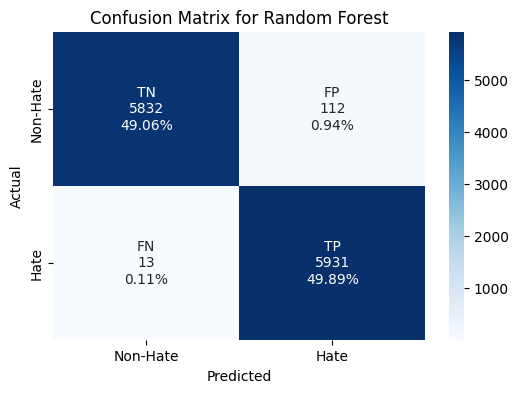

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Non-Hate       1.00      0.98      0.99      5944
        Hate       0.98      1.00      0.99      5944

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [ ]:
evaluate_model(y_test, rf_predictions, "Random Forest")

Evaluating XGBClassifier
Accuracy: 0.9016


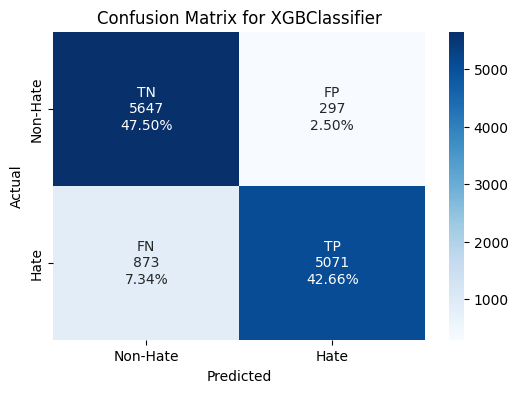

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

    Non-Hate       0.87      0.95      0.91      5944
        Hate       0.94      0.85      0.90      5944

    accuracy                           0.90     11888
   macro avg       0.91      0.90      0.90     11888
weighted avg       0.91      0.90      0.90     11888



In [ ]:
evaluate_model(y_test, xgb_predictions, "XGBClassifier")

Evaluating LSTM (Long Short-Term Memory)
Accuracy: 0.9848


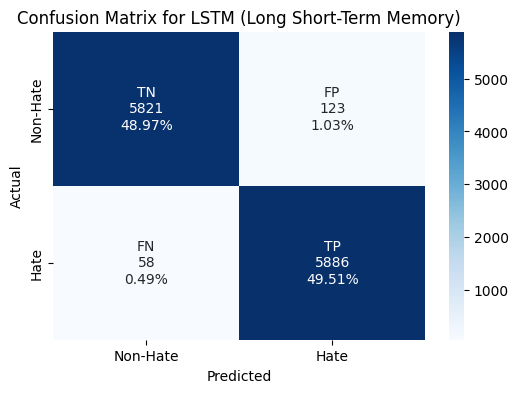

Classification Report for LSTM (Long Short-Term Memory):
              precision    recall  f1-score   support

    Non-Hate       0.99      0.98      0.98      5944
        Hate       0.98      0.99      0.98      5944

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [ ]:
evaluate_model(y_test_lstm, lstm_pred, 'LSTM (Long Short-Term Memory)')

Evaluating Transformer-based Model (BERT)
Accuracy: 0.9870


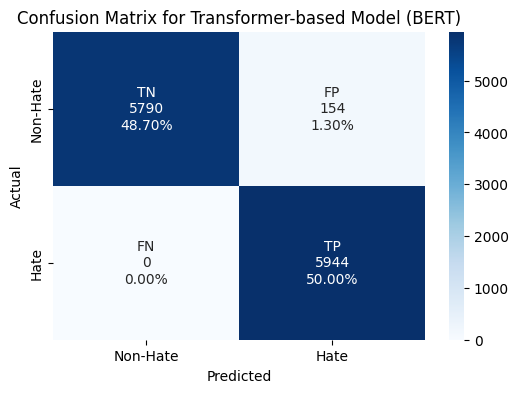

Classification Report for Transformer-based Model (BERT):
              precision    recall  f1-score   support

    Non-Hate       1.00      0.97      0.99      5944
        Hate       0.97      1.00      0.99      5944

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [ ]:
evaluate_model(true_labels, bert_pred, "Transformer-based Model (BERT)")

From the confusion matrix and classification report, all four models we used perform very well. The Random Forest has the highest accuracy (98.95%), while the XGBClassifier has the lowest accuracy (90.16%).

The Random Forest performs best on predicting non-hate tweets, while the Transformer (BERT) performs best on predicting hate tweets.

## 6.2 F1-Score

**F1-Score** is the harmonic mean of precision and recall. It balances precision and recall.

*   **Precision**: when we talk about the precision of the model, it usually means the ratio of true hate tweet predictions to the total number of hate tweet predictions (true positives + false positives). High precision means that when the model predicts a positive instance, it is usually correct.


*   **Recall (Sensitivity)**: when we talk about the sensitivity of the model, it usually means the ratio of true hate tweet predictions to the total number of actual hate tweets (true positives + false negatives). High recall means that the model captures most of the actual positive instances.

*   The F1 score is useful when we want to balance precision and recall, especially in cases where the classes are imbalanced. (In our case, we resample data to have balanced dataset.)

In [ ]:
f1 = {'model':['Random Forest', 'XGBClassifier',
               'LSTM', 'Transformer (BERT)'],
      'f1 score':[f1_score(y_test, rf_predictions, labels = [1, 0]),
                  f1_score(y_test, xgb_predictions, labels = [1, 0]),
                  f1_score(y_test_lstm, lstm_pred, labels = [1, 0]),
                  f1_score(true_labels, bert_pred, labels = [1, 0])]}

f1 = pd.DataFrame(f1)
f1

,model,f1 score
0,Random Forest,0.989572
1,XGBClassifier,0.896570
2,LSTM,0.984857
3,Transformer (BERT),0.987211


The Random Forest model has the best trade-off between precision and recall, which means that it performs well in identifying hate tweets and correctly predicting non-hate tweets.

## 6.3 ROC-AUC Score

The ROC-AUC score is a performance metric for evaluating the quality of a binary classification model. ROC stands for **Receiver Operating Characteristic**, and AUC stands for **Area Under the Curve**. It provides insight into the model's ability to distinguish between positive and negative classes across different threshold values. A higher ROC-AUC score indicates better overall performance and discrimination capability of the model.

In [ ]:
roc_auc_rf = roc_auc_score(y_test, rf_predictions)
roc_auc_xgb = roc_auc_score(y_test, xgb_predictions)
roc_auc_lstm = roc_auc_score(y_test_lstm, lstm_pred)
roc_auc_bert = roc_auc_score(true_labels, bert_pred)

In [ ]:
roc_auc_score = {'model':['Random Forest', 'XGBClassifier',
                          'LSTM', 'Transformer (BERT)'],
      'ROC-AUC score':[round(roc_auc_rf, 6),
                       round(roc_auc_xgb, 6),
                       round(roc_auc_lstm, 6),
                       round(roc_auc_bert, 6)]}

roc_auc_score = pd.DataFrame(roc_auc_score)
roc_auc_score

,model,ROC-AUC score
0,Random Forest,0.989485
1,XGBClassifier,0.901581
2,LSTM,0.984775
3,Transformer (BERT),0.987046


The Random Forest model has the highest ROC-AUC score, which means that it has the best overall performance and discrimination capability of all four models we used.

## 6.4 ROC Curve

The ROC curve is a graphical plot that shows the diagnostic ability of a binary classifier system as its discrimination threshold is varied (each point in the curve means a different classification threshold). It plots the **true positive rate (Recall**: the proportion of actual hate tweets that are correctly identified by the model) against the **false positive rate (1 - specificity**: the proportion of actual non-hate tweet that are incorrectly identified as hate tweet by the model) at various threshold settings.

The AUC score represents the area under this curve and provides an aggregate measure of performance across all possible classification thresholds. The AUC score ranges from 0 to 1, where a score of 1 indicates perfect classification and a score of 0.5 indicates performance no better than random guessing.

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_predictions)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_lstm, lstm_pred)
fpr_bert, tpr_bert, _ = roc_curve(true_labels, bert_pred)

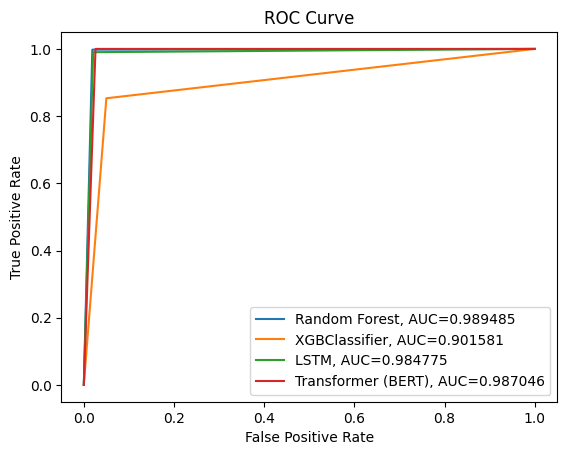

In [ ]:
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest, AUC=' + str(round(roc_auc_rf, 6)))
plt.plot(fpr_xgb, tpr_xgb, label = 'XGBClassifier, AUC=' + str(round(roc_auc_xgb, 6)))
plt.plot(fpr_lstm, tpr_lstm, label = 'LSTM, AUC=' + str(round(roc_auc_lstm, 6)))
plt.plot(fpr_bert, tpr_bert, label = 'Transformer (BERT), AUC=' + str(round(roc_auc_bert, 6)))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()

From the plot, the Random Forest model has the highest AUC (area under the curve). It is the blue line, which is overlapped with red line and green line. This model has the best ability to distinguish between hate and non-hate tweets across different threshold settings.

$\rule{800pt}{20pt}$

# 7. Inference

## 7.1 Load the vectorizer and model

In [ ]:
vectorizer = open('../Keras_model/vectorizer.pkl', 'rb')
vectorizer = pickle.load(vectorizer)
vectorizer

TfidfVectorizer(max_features=4000)

In [ ]:
model = open('../Keras_model/rf_model.pkl', 'rb')
model = pickle.load(model)
model

RandomForestClassifier(random_state=42)

## 7.2 Make new predictions

In [ ]:
# Predict non-hate speech
tweet = ['Had a fantastic day volunteering at the local animal shelter!']
vec = vectorizer.transform(tweet).toarray()
label = model.predict(vec)

if label == 1:
  print('This is a hate tweet.')
else:
  print('This is a non-hate tweet.')

This is a non-hate tweet.


In [ ]:
# Predict hate speech
tweet = ['I support white supremacy, white people should rule the world']
vec = vectorizer.transform(tweet).toarray()
label = model.predict(vec)

if label == 1:
  print('This is a hate tweet.')
else:
  print('This is a non-hate tweet.')

This is a hate tweet.
